In [2]:
# Dataset load
import pandas as pd
data = pd.read_csv('dataset/haberman.csv')
# Dataset split into trainset testset 5:1 ratio
from sklearn.model_selection import train_test_split
trainset, testset = train_test_split(data,test_size=0.2,random_state=1234, shuffle=True)


In [3]:
# Splitting into x_train, y_train, x_test, y_test 
# Changing class value from 1, 2 to 0, 1
x_train, y_train = [], []

for i in range(len(trainset)):
    x_train.append(list(trainset.iloc[i, 0:3]))
    y_train.append(list(trainset.iloc[i, 3:4])[0])

x_test, y_test = [], []

for i in range(len(testset)):
    x_test.append(list(testset.iloc[i, 0:3]))
    y_test.append(list(testset.iloc[i, 3:4])[0])
    
for i in range(len(y_train)):
    if y_train[i] == 2:
        y_train[i] = 1
    else:
        y_train[i] = 0
for i in range(len(y_test)):
    if y_test[i] == 2:
        y_test[i] = 1
    else:
        y_test[i] = 0

In [22]:
# Data scaling with MaxAbsScaler
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import BasicAer, IBMQ
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import algorithm_globals
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [10]:
from qiskit import BasicAer, IBMQ
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, ADAM
from qiskit.utils import algorithm_globals
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, EfficientSU2, RealAmplitudes
from qiskit.utils import QuantumInstance
from qiskit_aer import AerSimulator
from qiskit_ionq import IonQProvider
seed = 12345
algorithm_globals.random_seed = seed
provider = IBMQ.get_provider(hub='ibm-q-skku', group='snu', project='snu-students') # put your hub, groups, project in IBMQ.get_provider()

In [98]:
# backend = BasicAer.get_backend("statevector_simulator")
# backend = AerSimulator.from_backend(provider.get_backend('ibm_sherbrooke'))
backend = provider.get_backend('ibmq_montreal')

In [99]:
# Define QuantumInstance
quantum_instance = QuantumInstance(
    backend = backend,
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
    shots = 1024
)

In [ ]:
feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement='full')
optimizer = COBYLA(maxiter = 30)
var_form =  RealAmplitudes(num_qubits=3, entanglement='full', reps = 3)

vqc = VQC(optimizer = optimizer, loss = 'cross_entropy', feature_map = feature_map, ansatz = var_form, quantum_instance = quantum_instance)

vqc.fit(np.array(x_train_scaled), np.array(y_train))
y_hat = vqc.predict(x_test_scaled) 

In [85]:
# Print Accuracy, Precision, Recall, F1-Score of predicted labels
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("accuracy : %.4f" % accuracy_score(y_test,y_hat))
print("precision : %.4f" % precision_score(y_test, y_hat))
print("recall : %.4f" % recall_score(y_test, y_hat))
print("F1-Score : %.4f" % f1_score(y_test, y_hat))

accuracy : 0.6774
precision : 0.5294
recall : 0.4286
F1-Score : 0.4737


Adding Dynamical decoupling for VQC, we will add DD in ansatz.

In [101]:
from qiskit.circuit.library import XGate, YGate
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling
backend = AerSimulator.from_backend(provider.get_backend('ibm_sherbrooke'))
durations = InstructionDurations.from_backend(backend)
# dd_sequence = [XGate(), XGate()]
# spacing = [1/4, 1/2, 1/4]
dd_sequence = [XGate(), YGate(), XGate(), YGate()]
spacing = [0, 1/4, 1/4, 1/4, 1/4]
constraints = backend.configuration().timing_constraints

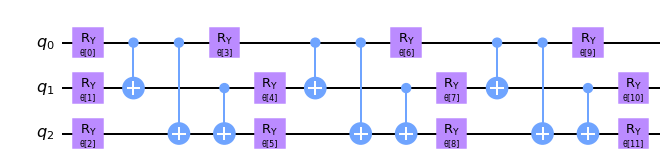

In [102]:
from qiskit.transpiler import PassManager, InstructionDurations
var_form = RealAmplitudes(num_qubits=3, entanglement='full', reps = 3).decompose()
properties = backend.properties()
var_form.draw('mpl')

Like we did in QSVM method.ipynb, we will get gate length from transpiled circuit

C:\Users\c5517\AppData\Local\Temp\ipykernel_37540\2148273530.py:8: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qubit = [gate[1][i].index for i in range(len(gate[1]))]


3424


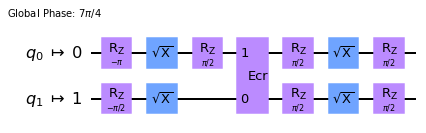

In [103]:
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
circ = QuantumCircuit(3,3)
circ.cx(0,1)
tc_p = transpile(circ, backend = backend)
length_cx = 0
for gate in tc_p:
    qubit = [gate[1][i].index for i in range(len(gate[1]))]
    name = gate[0].name
    length = properties.gate_length(str(name), qubit)
    length_cx += length
length_cx = round(length_cx * 9/2 * 1e9) # convert second to dt unit
print(length_cx)
tc_p.draw('mpl', idle_wires=False)

256


C:\Users\c5517\AppData\Local\Temp\ipykernel_37540\2776227557.py:8: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qubit = [gate[1][i].index for i in range(len(gate[1]))]


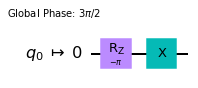

In [104]:
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
circ = QuantumCircuit(3,3)
circ.ry(np.pi,0)
tc_ry = transpile(circ, backend = backend)
length_ry = 0
for gate in tc_ry:
    qubit = [gate[1][i].index for i in range(len(gate[1]))]
    name = gate[0].name
    length = properties.gate_length(str(name), qubit)
    length_ry += length
length_ry = round(length_ry * 9/2 * 1e9) # convert second to dt unit
print(length_ry)
tc_ry.draw('mpl', idle_wires=False)

In [105]:
for gate in var_form:
    qubit = [gate[1][i].index for i in range(len(gate[1]))]
    name = gate[0].name
    if gate[0] in backend._basis_gates():
        length = properties.get_length(str(name), qubit)
    elif name == 'cx':
         length = length_cx
    durations.update(InstructionDurations([(str(name), qubit, length)]))
for i in range(3):
    durations.update(InstructionDurations([('ry', i, length_ry)]))
    durations.update(InstructionDurations([('y', i, length_ry)])) # Duration of y gate and ry gate is same.
pm = PassManager([ALAPScheduleAnalysis(durations),
                  PadDynamicalDecoupling(durations, dd_sequence, spacing=spacing,
                                         pulse_alignment=constraints['pulse_alignment'])])

C:\Users\c5517\AppData\Local\Temp\ipykernel_37540\3116549166.py:2: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qubit = [gate[1][i].index for i in range(len(gate[1]))]


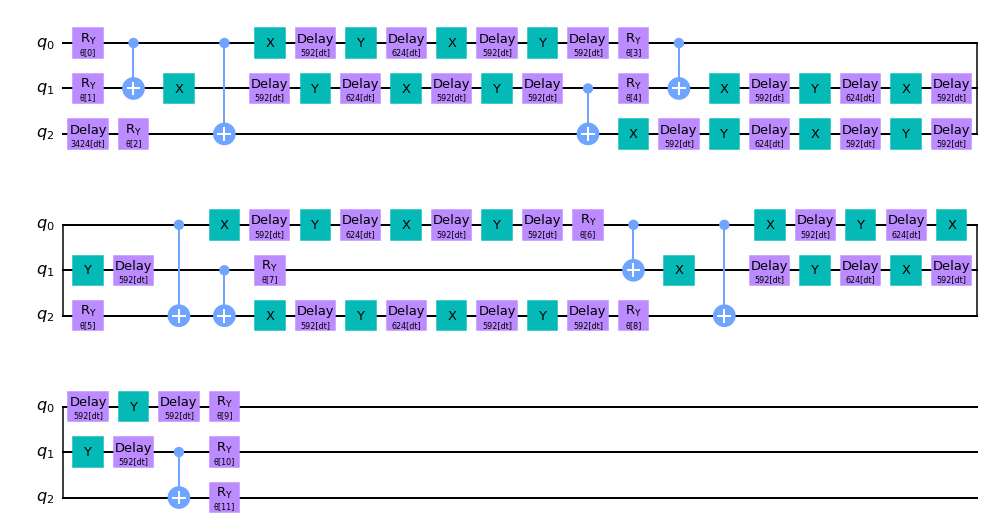

In [106]:
var_form = pm.run(var_form)
var_form.draw('mpl', fold = 20)

Now, we can run VQC with ansatz which has DD sequence in it
If needed, we can use more various DD sequences

In [ ]:
feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement='full')
optimizer = COBYLA(maxiter = 30)
var_form =  var_form

vqc = VQC(optimizer = optimizer, loss = 'cross_entropy', feature_map = feature_map, ansatz = var_form, quantum_instance = quantum_instance)

vqc.fit(np.array(x_train_scaled), np.array(y_train))
y_hat = vqc.predict(x_test_scaled) 

In [ ]:
# Print Accuracy, Precision, Recall, F1-Score of predicted labels
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("accuracy : %.4f" % accuracy_score(y_test,y_hat))
print("precision : %.4f" % precision_score(y_test, y_hat))
print("recall : %.4f" % recall_score(y_test, y_hat))
print("F1-Score : %.4f" % f1_score(y_test, y_hat))